# Pliable Lasso in Python

This will all use the same example found in the pliable lasso paper.

In [1]:
import numpy as np
import numpy.linalg as la
import cvxpy as cvx

import matplotlib.pyplot as graph
import seaborn as sns

from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


def v2a(a):
    return a.reshape((len(a), 1))


graph.style.use('fivethirtyeight')
print(cvx.__version__)  # Make sure it's 1.0.11 or greater

1.0.11


## First Classical Lasso

$ y = X \beta $

$ J(\beta, \lambda) = ||X \beta||_2^2 + \lambda||\beta||_1 $

In [2]:
# Fake data
n = 10000
p = 50
k = 4

beta = np.zeros(p)
beta[:4] = [2, -2, 2, 2]
print(beta)

x = stats.norm().rvs(size=(n, p))
y = x @ beta
y += 0.5*stats.norm().rvs(n)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(x.shape, y.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

[ 2. -2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(10000, 50) (10000,)
(8000, 50) (2000, 50) (8000,) (2000,)


In [3]:
def y_hat(x, beta):
    return x @ beta


def mse(x, y, beta):
    return cvx.norm(y_hat(x, beta) - y, p=2) ** 2


def penalty(lam, beta):
    return lam * cvx.norm(beta, p=1)


def j(x, y, beta, lam):
    return mse(x, y, beta) + penalty(lam, beta)

In [4]:
# Setup
beta_hat = cvx.Variable(p)
lam = cvx.Parameter(nonneg=True)
problem = cvx.Problem(cvx.Minimize(
    j(x_train, y_train, beta_hat, lam)
))

C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


In [5]:
%%time
lambdas = np.logspace(3, -3, 30)  # I know this is a list of large lambda values.

test_scores = []
beta_path = []
for lam_i in lambdas:
    lam.value = lam_i
    problem_result = problem.solve(verbose=True, solver=cvx.CVXOPT)
    
    test_scores.append(r2_score(y_test, x_test @ beta_hat.value))
    beta_path.append(beta_hat.value)
    
beta_path = np.vstack(beta_path)
print(beta_path.shape)

C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  2e+06  1e+00  2e-03  1e+00
 1:  1.7272e+02  1.9994e+02  2e+06  1e+00  2e-03  3e+01
 2:  4.1693e+02  5.1525e+02  3e+06  1e+00  2e-03  1e+02
 3: -7.4488e+01  1.2193e+02  3e+06  2e+00  3e-03  2e+02
 4:  2.3025e+02  3.5837e+02  2e+06  9e-01  2e-03  1e+02
 5:  6.6593e+02  8.5958e+02  2e+06  1e+00  2e-03  2e+02
 6:  1.5782e+03  1.6936e+03  7e+05  4e-01  7e-04  1e+02
 7:  1.9959e+03  2.1472e+03  8e+05  4e-01  7e-04  2e+02
 8:  3.8172e+03  3.8719e+03  2e+05  1e-01  2e-04  5e+01
 9:  4.5918e+03  4.6601e+03  3e+05  2e-01  2e-04  7e+01
10:  6.6140e+03  6.7103e+03  3e+05  1e-01  2e-04  1e+02
11:  8.2790e+03  8.3059e+03  7e+04  4e-02  6e-05  3e+01
12:  8.5950e+03  8.6272e+03  8e+04  4e-02  7e-05  3e+01
13:  9.1198e+03  9.1377e+03  4e+04  2e-02  3e-05  2e+01
14:  9.4874e+03  9.4998e+03  2e+04  1e-02  2e-05  1e+01
15:  9.7521e+03  9.7546e+03  4e+03  2e-03  4e-06  2e+00
16:  9.7300e+03  9.7336e+03  5e+03  3e-03  5e-06  

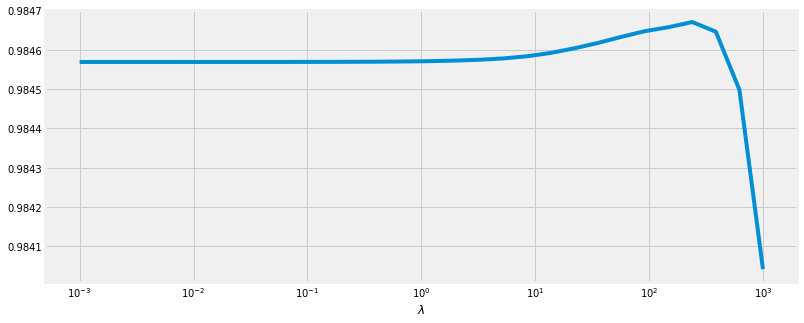

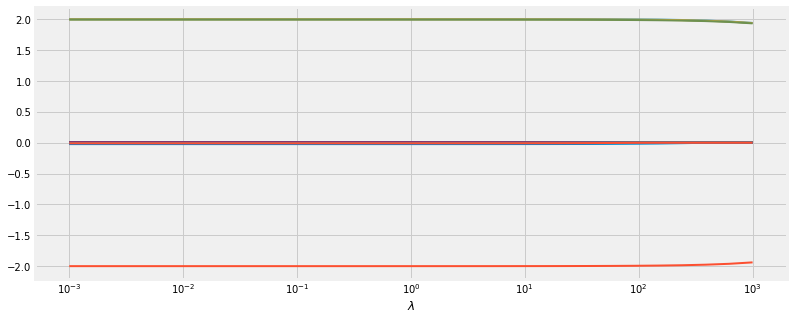

In [6]:
graph.figure(figsize=(12, 5))
graph.plot(lambdas, test_scores)
graph.xscale('log')
graph.xlabel(r'$\lambda$')
graph.show()

graph.figure(figsize=(12, 5))
for p_i in range(p):
    graph.plot(lambdas, beta_path[:, p_i], linewidth=2)
graph.xscale('log')
graph.xlabel(r'$\lambda$')
graph.show()

## Now the Pliable Lasso

$ y = \beta_0 1 + Z \theta_0 + \sum X_j(\beta_j 1 + Z \theta_j) $

$ J(\beta_0, \theta_0, \beta, \theta) = {{1}\over{2N}} \sum$

In [7]:
beta_0 = 0
theta_0 = np.zeros(k)

beta = np.zeros(p)
beta[:4] = [2, -2, 2, 2]

theta = np.zeros((p, k))
theta[2, 0] = 2.0
theta[3, 1] = -2.0

z = stats.bernoulli(p=0.5).rvs(size=(n, k))
print(z.shape)

y = x[:, 0] * beta[0]
y += x[:, 1] * beta[1]
y += x[:, 2] * (beta[2] + 2*z[:, 0])
y += x[:, 3] * (beta[3] - 2*z[:, 1])

y_gt = y.copy()
y += 0.5 * stats.norm().rvs(n)  # Add noise from paper

# Train test split
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

print(x.shape, y.shape, z.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, z_train.shape, z_test.shape)

(10000, 4)
(10000, 50) (10000,) (10000, 4)
(8000, 50) (2000, 50) (8000,) (2000,) (8000, 4) (2000, 4)


In [8]:
def check_properties(obj, name=''):
    print(name, f'DCP {obj.is_dcp()}', f'Convexity {obj.is_convex()}')

In [9]:
# Functions
def compute_w_j(x, z, j):
    k = z.shape[1]
    x_j = np.tile(v2a(x[:, j]), (1, k))
    return x_j * z


def y_hat(beta_0, theta_0, beta, theta, x, z):  # Confirmed DCP and Convex
    n = x.shape[0]
    p = x.shape[1]
    k = z.shape[1]
    
    intercepts = beta_0 + (z @ theta_0)
    
    shared_model = x @ beta
    
    pliables = np.zeros(n)
    for j_i in range(p):
        w_j = compute_w_j(x, z, j_i)
        pliables = pliables + (w_j @ theta[j_i, :])
        
    output = intercepts + shared_model + pliables
    return output


def j(beta_0, theta_0, beta, theta, x, y, z, alpha, lam):
    n, p = x.shape
    
    # mse = (1/(2*n)) * cvx.sum((y - y_hat(beta_0, theta_0, beta, theta, x, z))**2)
    mse = cvx.norm((y - y_hat(beta_0, theta_0, beta, theta, x, z)), p=2)**2
    
    beta_matrix = cvx.reshape(beta, (p, 1))
    
    penalty_1 = cvx.sum(cvx.norm(cvx.hstack([beta_matrix, theta]), p=2, axis=1))
    penalty_2 = cvx.sum(cvx.norm(theta, p=2, axis=1))
    penalty_3 = cvx.sum(cvx.norm(theta, p=1))
    
    loss = mse + (1-alpha) * lam * (penalty_1 + penalty_2) + alpha * lam * penalty_3
    check_properties(loss, 'loss')
    return loss

In [10]:
# Setup
# Parameters
beta_hat_0 = cvx.Variable(1)
theta_hat_0 = cvx.Variable(k)
beta_hat = cvx.Variable(p)
theta_hat = cvx.Variable((p, k))

print('beta_0', beta_hat_0.shape)
print('theta_0', theta_hat_0.shape)
print('beta', beta_hat.shape)
print('theta', theta_hat.shape)
print('='*20)

# Hyperparameters
alpha = 0.5
lam = cvx.Parameter(nonneg=True)
lam.value = 1e2

# Solve
problem = cvx.Problem(
    cvx.Minimize(j(beta_hat_0, theta_hat_0, beta_hat, theta_hat, x_train, y_train, z_train, alpha, lam))
)

beta_0 (1,)
theta_0 (4,)
beta (50,)
theta (50, 4)
loss DCP True Convexity True


C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


In [11]:
%%time
problem.solve(verbose=True, solver=cvx.CVXOPT, max_iter=500)

C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  4e+05  3e+00  4e-02  1e+00
 1:  2.5037e+02  2.6421e+02  4e+05  3e+00  4e-02  2e+01
 2:  3.3346e+02  4.0241e+02  5e+05  3e+00  5e-02  7e+01
 3:  5.3806e+02  5.6321e+02  1e+05  1e+00  1e-02  3e+01
 4:  6.3788e+02  6.5630e+02  8e+04  5e-01  8e-03  2e+01
 5:  1.1953e+03  1.2157e+03  8e+04  6e-01  8e-03  2e+01
 6:  8.1622e+02  8.5124e+02  1e+05  7e-01  1e-02  4e+01
 7:  1.2606e+03  1.2747e+03  4e+04  3e-01  4e-03  1e+01
 8:  1.8686e+03  1.8844e+03  4e+04  3e-01  4e-03  2e+01
 9:  1.7715e+03  1.7861e+03  3e+04  2e-01  3e-03  1e+01
10:  2.2480e+03  2.2528e+03  1e+04  7e-02  9e-04  5e+00
11:  2.5738e+03  2.5795e+03  1e+04  8e-02  1e-03  6e+00
12:  2.5653e+03  2.5681e+03  5e+03  3e-02  4e-04  3e+00
13:  2.6567e+03  2.6574e+03  1e+03  7e-03  1e-04  7e-01
14:  2.7045e+03  2.7051e+03  1e+03  7e-03  9e-05  7e-01
15:  2.7251e+03  2.7253e+03  4e+02  2e-03  3e-05  2e-01
16:  2.7468e+03  2.7470e+03  4e+02  3e-03  4e-05  

2785.3579370757952

In [12]:
%%time
lambdas = np.logspace(6, -1, 20)

test_scores = []
beta_0_path = []
theta_0_path = []
beta_path = []
theta_path = []
for lam_i in lambdas:
    lam.value = lam_i
    print(f'lam {lam_i}')
    soln = problem.solve(verbose=True, solver=cvx.CVXOPT, max_iter=500)
    
    test_scores.append(
        r2_score(
            y_test, 
            y_hat(beta_hat_0.value, theta_hat_0.value, beta_hat.value, theta_hat.value, x_test, z_test))
    )
    beta_0_path.append(beta_hat_0.value)
    theta_0_path.append(theta_hat_0.value)
    beta_path.append(beta_hat.value)
    theta_path.append(theta_hat.value.flatten())
    
theta_0_path = np.vstack(theta_0_path)
beta_path = np.vstack(beta_path)
theta_path = np.vstack(theta_path)

lam 1000000.0


C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:661: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\antho\Miniconda3\lib\site-packages\cvxpy\problems\problem.py:662: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  3e+09  3e+00  4e-06  1e+00
 1:  1.1188e+02  1.4268e+02  3e+09  3e+00  4e-06  3e+01
 2:  2.1677e+02  3.6574e+02  3e+09  3e+00  4e-06  2e+02
 3: -2.9386e+02 -7.4700e+01  3e+09  3e+00  4e-06  2e+02
 4: -9.0868e+01  2.3806e+02  3e+09  3e+00  4e-06  3e+02
 5: -1.9586e+02  5.5447e+02  3e+09  3e+00  4e-06  8e+02
 6: -1.6461e+03 -3.8017e+02  3e+09  3e+00  4e-06  1e+03
 7: -1.4385e+03  8.3800e+02  3e+09  3e+00  4e-06  2e+03
 8: -5.8223e+03  8.3521e+01  3e+09  2e+00  3e-06  6e+03
 9: -1.0216e+04 -1.5736e+02  3e+09  2e+00  3e-06  1e+04
10: -1.0777e+04  1.5082e+03  3e+09  2e+00  3e-06  1e+04
11: -1.9592e+04  9.2926e+02  3e+09  2e+00  3e-06  2e+04
12: -2.2707e+04  3.9032e+03  2e+09  1e+00  2e-06  3e+04
13: -4.8032e+03  3.0943e+04  1e+09  9e-01  1e-06  4e+04
14:  2.5653e+04  5.5571e+04  4e+08  3e-01  4e-07  3e+04
15:  7.0048e+04  1.0671e+05  4e+08  3e-01  4e-07  4e+04
16:  6.1115e+04  8.9729e+04  1e+08  1e-01  1e-07  

SolverError: Solver 'CVXOPT' failed. Try another solver or solve with verbose=True for more information. Try recentering the problem data around 0 and rescaling to reduce the dynamic range.

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

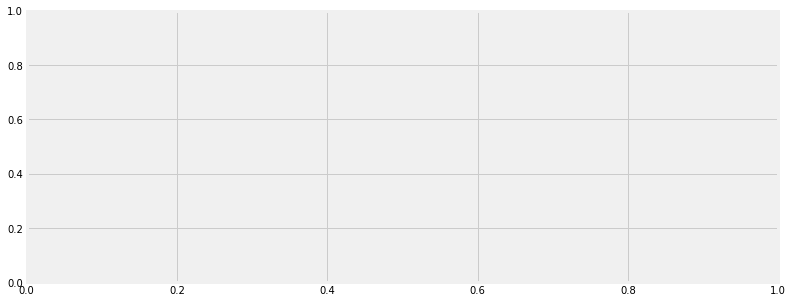

In [13]:
graph.figure(figsize=(12, 5))
graph.plot(lambdas, test_scores)
graph.xscale('log')
graph.show()

graph.figure(figsize=(12, 5))
graph.title('Betas')
graph.plot(lambdas, beta_0_path, linewidth=2, alpha=0.33, color='black')
for p_i in range(p):
    graph.plot(lambdas, beta_path[:, p_i], linewidth=2)
graph.xscale('log')
graph.xlabel(r'$\lambda$')
graph.show()

graph.figure(figsize=(12, 5))
graph.title('Thetas')
for k_i in range(k):
    graph.plot(lambdas, theta_0_path[:, k_i], linewidth=2, alpha=0.33, color='black')
for pk_i in range(p*k):
    graph.plot(lambdas, theta_path[:, pk_i], linewidth=2)
graph.xscale('log')
graph.xlabel(r'$\lambda$')
graph.show()